## Autoencoder feature analysis
In this notebook we extract features from the original dataset and analyse the feature distributions. <br>
Samples are represented as an array of tipe:<br>
$x_0,\,y_0,\,z_0,\,x_1,\,y_1,\,z_1,\,...,\,x_n,\,y_n\,z_n,\, 0,\,0\,...\,0$ <br>
Where n is the number of hits in the track, and zero-padding is applied to match the same array dimension for every track in the dataset.

In [64]:
import yaml
from quake.utils.utils import load_runcard, save_runcard
from quake.models.autoencoder.autoencoder_dataloading import read_data
from quake.models.autoencoder.train import load_and_compile_network
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from quake.models.qsvm.qsvm_tester import get_features

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA, TruncatedSVD

In [65]:
# Loading the dataset
data_folder = Path("../../output_2_trial/data")
train_folder = Path("../../output_2_trial/models/autoencoder")
setup = load_runcard("../../output_2_trial/cards/runcard.yaml")
setup["run_tf_eagerly"] = False
setup["seed"] = 42
train_generator, val_generator, test_generator = read_data(
    data_folder, train_folder, setup, split_from_maps=True
)
msetup = setup["model"]["autoencoder"]
max_input_nb = np.max(
    [
        train_generator.fixed_length_inputs.shape[1],
        val_generator.fixed_length_inputs.shape[1],
        test_generator.fixed_length_inputs.shape[1],
    ]
)
print(f"Arrays are padded to match dimension {max_input_nb}")

[INFO] (quake.autoencoder) Loading splitting maps from folder: ../../output_2_trial/models/autoencoder
INFO:quake.autoencoder:Loading splitting maps from folder: ../../output_2_trial/models/autoencoder
[INFO] (quake.autoencoder) Train dataset balancing: 125517 training points, of which 50.03% positives
INFO:quake.autoencoder:Train dataset balancing: 125517 training points, of which 50.03% positives
[INFO] (quake.autoencoder) Validation dataset balancing: 26897 training points, of which 49.60% positives
INFO:quake.autoencoder:Validation dataset balancing: 26897 training points, of which 49.60% positives
[INFO] (quake.autoencoder) Test dataset balancing: 26897 training points, of which 50.31% positives
INFO:quake.autoencoder:Test dataset balancing: 26897 training points, of which 50.31% positives


Arrays are padded to match dimension 76


In [66]:
msetup.update({"ckpt": train_folder.parent / f"autoencoder/autoencoder.h5"})

# Loading the network
network = load_and_compile_network(msetup, setup["run_tf_eagerly"], max_input_nb)

[INFO] (quake.autoencoder) Loading weights at ../../output_2_trial/models/autoencoder/autoencoder.h5
INFO:quake.autoencoder:Loading weights at ../../output_2_trial/models/autoencoder/autoencoder.h5


In [67]:
network.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Enc0 (LBAD)                 multiple                  15400     
                                                                 
 Enc1 (LBAD)                 multiple                  120600    
                                                                 
 Enc2 (LBAD)                 multiple                  150250    
                                                                 
 Enc3 (LBAD)                 multiple                  25100     
                                                                 
 Enc4 (LBAD)                 multiple                  2020      
                                                                 
 Dec0 (LBAD)                 multiple                  2100      
                                                                 
 Dec1 (LBAD)                 multiple                  

In [68]:
# Computing autoencoder predictions
validation_preds = network.predict(val_generator)

# Computing autoencoder performance (MSE metric)
network.evaluate(val_generator)

538/538 [==============================] - 1s 2ms/step - loss: 0.0123 - MSE: 0.0123


[0.01232849806547165, 0.01232849806547165]

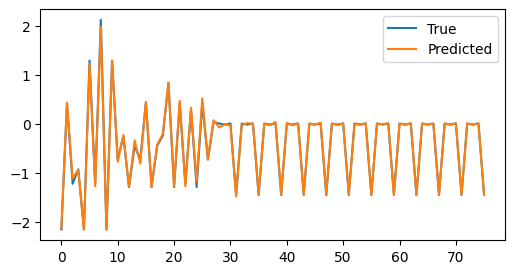

In [69]:
# Displaying the true value vs the autoencoder prediction
track_id = 2134
plt.figure(figsize=(6, 3))
plt.plot(val_generator.inputs[track_id])
plt.plot(validation_preds[track_id])
plt.legend(["True", "Predicted"])

In [70]:
# Loading features from the autoencoder latent space
# dataset and labels are lists. To get training, validation and test data, call entry 0, 1 and 2 respectively
dataset, labels = get_features(data_folder.parent, "autoencoder", setup)
latent_dim = dataset[0].shape[1]

print(f"Latent space dimension: {latent_dim}")

[INFO] (quake.autoencoder) Loading splitting maps from folder: ../../output_2_trial/models/autoencoder
INFO:quake.autoencoder:Loading splitting maps from folder: ../../output_2_trial/models/autoencoder
[INFO] (quake.autoencoder) Train dataset balancing: 125517 training points, of which 50.03% positives
INFO:quake.autoencoder:Train dataset balancing: 125517 training points, of which 50.03% positives
[INFO] (quake.autoencoder) Validation dataset balancing: 26897 training points, of which 49.60% positives
INFO:quake.autoencoder:Validation dataset balancing: 26897 training points, of which 49.60% positives
[INFO] (quake.autoencoder) Test dataset balancing: 26897 training points, of which 50.31% positives
INFO:quake.autoencoder:Test dataset balancing: 26897 training points, of which 50.31% positives
[INFO] (quake.autoencoder) Loading weights at ../../output_2_trial/models/autoencoder/autoencoder.h5
INFO:quake.autoencoder:Loading weights at ../../output_2_trial/models/autoencoder/autoencoder

538/538 [==============================] - 1s 1ms/step
Latent space dimension: 20


In [71]:
# Rescaling features from 0 to 1
scaler = MinMaxScaler((0, 1))
dataset_train = scaler.fit_transform(dataset[0])

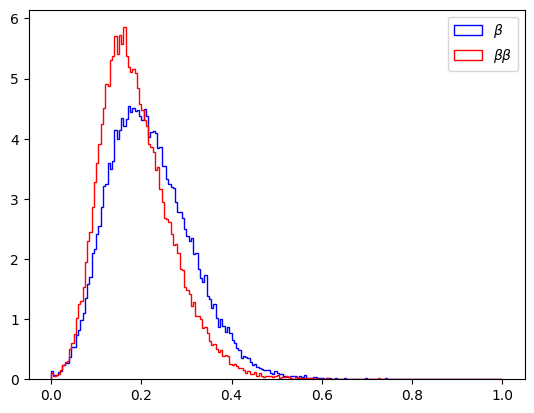

In [101]:
# Plotting feature distributions within classes
feature_nb = 14
plt.hist(
    dataset_train[labels[0] == 0, feature_nb],
    range=[0, 1],
    bins=200,
    histtype="step",
    density=True,
    color="blue",
)[-1]
plt.hist(
    dataset_train[labels[0] == 1, feature_nb],
    range=[0, 1],
    bins=200,
    histtype="step",
    density=True,
    color="red",
)[-1]
plt.legend([r"$\beta$", r"$\beta\beta$"])

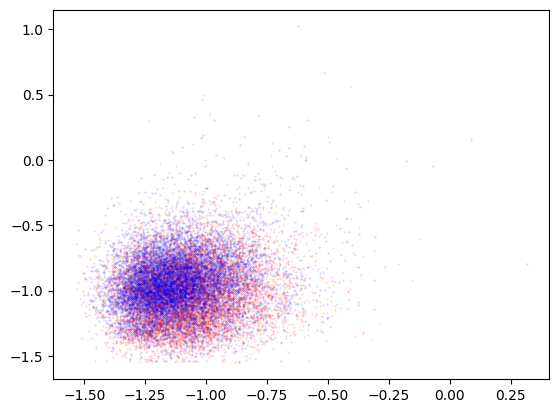

In [73]:
# 2D scatterplots
ft_1_idx = 3
ft_2_idx = 4
plt.scatter(
    x=dataset[0][labels[0] == 0, ft_1_idx][:10000],
    y=dataset[0][labels[0] == 0, ft_2_idx][:10000],
    s=0.1,
    alpha=0.3,
    c="r",
)
plt.scatter(
    x=dataset[0][labels[0] == 1, ft_1_idx][:10000],
    y=dataset[0][labels[0] == 1, ft_2_idx][:10000],
    s=0.1,
    alpha=0.3,
    c="b",
)

In [74]:
# Doing univariate analysis
label_relation = mutual_info_classif(dataset_train, labels[0])
print(label_relation)

[0.00033628 0.0064139  0.02412181 0.00453871 0.01339958 0.03046074
 0.00536117 0.01269047 0.00481966 0.00268783 0.00258929 0.01001939
 0.00998193 0.00933486 0.01700596 0.0135228  0.00208952 0.00426722
 0.00048222 0.00566402]


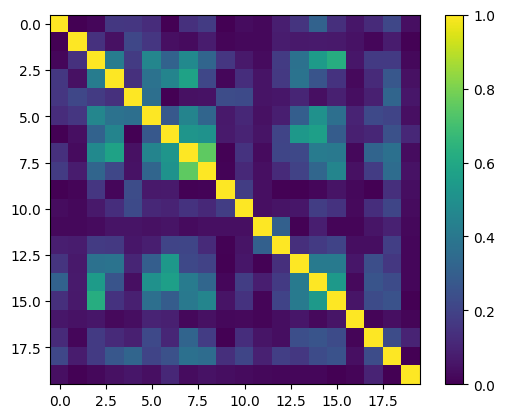

In [75]:
# Plotting linear correlations between features
corrmat = np.abs(np.corrcoef(dataset[0].T))
plt.imshow(corrmat, clim=[0.0, 1])
plt.colorbar()

In [76]:
# Preparing a subset for training an SVM
ds_train = scaler.transform(dataset[0])[:10000]  # dataset is already shuffled
ds_val = scaler.transform(dataset[1])[:10000]
ds_test = scaler.transform(dataset[2])[:10000]

In [102]:
# Training a gaussian SVM and optimizing hyperparameters
# With the settings below, it may take a few minutes to run.
param_grid = {
    "C": [0.1, 1, 10, 100, 1000, 10000],  # Regularization parameter
    "gamma": [0.01, 0.1, 1, 10, 100],  # Kernel coefficient for 'rbf' kernel
}

gaussian = SVC(kernel="rbf")

grid_search = GridSearchCV(gaussian, param_grid, cv=3, n_jobs=-1, verbose=1)

grid_search.fit(ds_train, labels[0][:10000])


best_C = grid_search.best_params_["C"]
best_gamma = grid_search.best_params_["gamma"]
best_model = grid_search.best_estimator_

gaussian_clf = SVC(kernel="rbf", C=best_C, gamma=best_gamma).fit(
    ds_train, labels[0][:10000]
)
accuracy_gau = gaussian_clf.score(ds_val, labels[1][:10000])

print("Best gaussian model is", best_model, "with accuracy", accuracy_gau)

linear_clf = SVC(kernel="linear").fit(ds_train, labels[0][:10000])
accuracy_lin = linear_clf.score(ds_val, labels[1][:10000])
print("Best linear model is accuracy:", accuracy_lin)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best gaussian model is SVC(C=1000, gamma=0.01, kernel='sigmoid') with accuracy 0.6203
Best linear model is accuracy: 0.6195


In [78]:
0.6586
0.6302

0.6302

In [79]:
# Doing PCA analysis
pca = PCA(n_components=latent_dim)
pca.fit(dataset_train)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.22804703 0.12400583 0.10697772 0.07745239 0.05825972 0.05521489
 0.05141541 0.04631232 0.04319267 0.03803772 0.03503091 0.03296581
 0.0266049  0.0209551  0.01732722 0.01537653 0.0094168  0.00772213
 0.00361097 0.00207394]
[65.04598  47.965538 44.550743 37.907547 32.87702  32.006367 30.88552
 29.31275  28.308268 26.56535  25.493767 24.730911 22.217186 19.71756
 17.929686 16.890303 13.21782  11.969523  8.185023  6.203066]


Text(0, 0.5, 'Total explained variance')

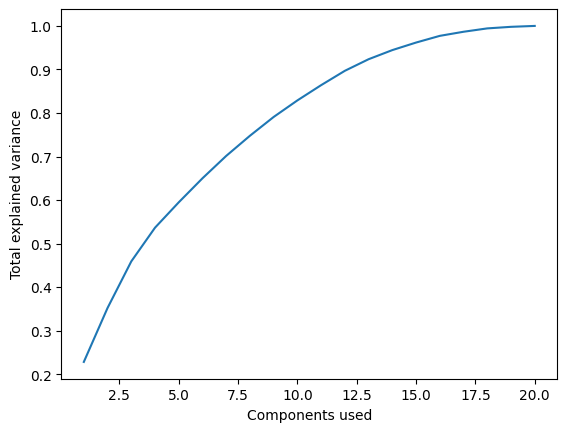

In [80]:
plt.plot(np.arange(1, latent_dim + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Components used")
plt.ylabel("Total explained variance")

In [81]:
# keeping only some components
nb_features_to_keep = 18
ds_train_transformed = pca.transform(dataset_train)[:, :nb_features_to_keep]
ds_val_transformed = pca.transform(ds_val)[:, :nb_features_to_keep]

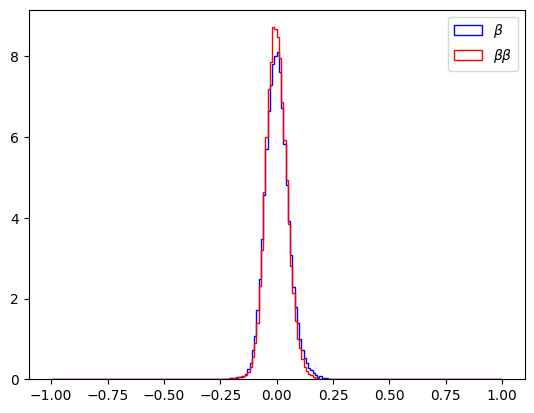

In [82]:
# Plotting feature distributions within classes
feature_nb = 14
plt.hist(
    ds_train_transformed[labels[0] == 0, feature_nb],
    range=[-1, 1],
    bins=200,
    histtype="step",
    density=True,
    color="blue",
)[-1]
plt.hist(
    ds_train_transformed[labels[0] == 1, feature_nb],
    range=[-1, 1],
    bins=200,
    histtype="step",
    density=True,
    color="red",
)[-1]
plt.legend([r"$\beta$", r"$\beta\beta$"])

In [83]:
label_relation = mutual_info_classif(ds_train_transformed, labels[0])
print(label_relation)

[0.02496162 0.00055789 0.00918309 0.0023863  0.00059706 0.00625228
 0.00237587 0.00677457 0.00245867 0.00016831 0.00457811 0.00066313
 0.0022559  0.00365802 0.00138529 0.00339819 0.00048868 0.0037427 ]


In [84]:
gaus = SVC(kernel="rbf", C=1, gamma=10)
gaus.fit(ds_train_transformed[:10000], labels[0][:10000])
gaus.score(ds_val_transformed[:10000], labels[1][:10000])

0.6444

In [85]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Generate some sample data
import numpy as np
from sklearn.model_selection import train_test_split

# Create a random dataset
np.random.seed(42)

# Create the neural network model
model = Sequential([
    Dense(320, activation='relu', input_shape=(18,)),
    Dropout(0.1),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(20, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
learning_rate = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(dataset[0], labels[0], batch_size=30, epochs=100, validation_data=(dataset[1], labels[1]))

# Evaluate the model on the test data
loss, accuracy = model.evaluate(dataset[2], labels[2])
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")


Epoch 1/100


ValueError: in user code:

    File "/home/rmoretti/TESI/tesienv/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/rmoretti/TESI/tesienv/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/rmoretti/TESI/tesienv/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/rmoretti/TESI/tesienv/lib/python3.9/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/home/rmoretti/TESI/tesienv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/rmoretti/TESI/tesienv/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 18), found shape=(None, 20)


In [ ]:
train_generator.inputs.shape

(125517, 76)

In [ ]:
dir(train_generator)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_keras_api_names',
 '_keras_api_names_v1',
 'batch_size',
 'classes',
 'data_len',
 'fixed_length_inputs',
 'get_extra_features',
 'indices',
 'inputs',
 'max_hit_length',
 'mus',
 'nb_features',
 'nb_hits_array',
 'on_epoch_end',
 'rng',
 'seed',
 'should_standardize',
 'sigmas',
 'spatial_dims',
 'targets',
 'use_spatial_dims']